In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
%matplotlib inline

In [2]:
sns.set(font_scale=1.5)

In [3]:
PATHS = glob.glob('ses*')

In [4]:
dfs = {}
for i, PATH in enumerate(PATHS):
    dfs['s'+str(i+1)] = pd.read_csv(PATH)

In [5]:
session = 's1'

In [6]:
first_half = len(dfs[session].columns.to_list())//2

## Possíveis problemas

### Análise das Primeiras 15 colunas

In [7]:
dfs[session].iloc[:,0:first_half].head()

,user_id,class_id,logins,comments,blank_line,lloc,count_if,count_loop,count_var,syntax_grade,log_rows,deleted_coef,writed_coef,pasted_coef
0,1278,102,11.0,40.0,9.0,93.0,9.0,0.0,54.0,0.526316,5109.0,0.110475,0.238127,0.651398
1,1279,102,4.0,1.0,4.0,7.0,0.0,0.0,3.0,0.078947,415.0,0.226415,0.773585,0.000000
2,1280,102,5.0,45.0,48.0,69.0,0.0,0.0,48.0,0.526316,4489.0,0.150166,0.488108,0.361726
3,1281,102,5.0,30.0,32.0,66.0,0.0,0.0,46.0,0.526316,5576.0,0.147767,0.665830,0.186402
4,1283,102,4.0,3.0,12.0,45.0,0.0,0.0,29.0,0.342105,7244.0,0.220782,0.580797,0.198422


* Os dados acima são da sessão 1, logo não fazem muito sentido altos valores nas seguintes colunas:
    * Alto valor em count_if
    * Alto valor em count_loop
    * Alto valor em count_var
    * seria bom verificar novamente todas essas variáveis que são baseadas na análise estática do código (usando o radon).
* Colunas com valores iguais:
    * sloc e lloc (isso pode acontecer, mas como parece ser frequente, **remova o sloc**).

In [8]:
df = dfs[session].iloc[:,2:first_half]
stats = df.describe()
stats.loc['skew'] = df.skew().tolist()
stats.loc['kurt'] = df.kurtosis().tolist()
stats

,logins,comments,blank_line,lloc,count_if,count_loop,count_var,syntax_grade,log_rows,deleted_coef,writed_coef,pasted_coef
count,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000
mean,11.579472,24.247882,18.076482,57.894121,0.633533,0.901345,37.539611,0.382356,4952.112108,0.173096,0.536842,0.290062
std,7.369844,18.535332,15.109982,20.682748,2.475122,1.847901,14.683315,0.193829,4099.796110,0.091313,0.209536,0.257480
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,6.000000,5.000000,49.000000,0.000000,0.000000,28.000000,0.292683,2321.500000,0.115685,0.418461,0.083827
50%,10.000000,27.000000,15.000000,63.500000,0.000000,0.500000,41.000000,0.342857,4178.000000,0.163869,0.573598,0.228070
75%,15.000000,39.000000,27.000000,73.000000,0.000000,1.000000,49.000000,0.500000,6401.000000,0.222401,0.688171,0.424465
max,82.000000,141.000000,121.000000,110.000000,25.000000,19.000000,65.000000,1.000000,50155.000000,0.714286,1.000000,1.000000
skew,1.869097,0.574855,1.087445,-1.065459,4.843617,4.682794,-0.816447,0.787800,2.392867,0.872730,-0.771266,1.065872
kurt,8.062115,1.593805,1.843855,0.571917,27.875491,27.745241,-0.149116,0.951647,12.920026,2.338382,0.173088,0.556284


* Os valores máximos são normalmente absurdos. Para ilustra:
    * Um aluno fez 2417 **logins** nas duas primeiras semanas de aula? Isso está certo?
    * Olha os valores das métricas baseadas nos códigos (comments, blank_lines, ...).
    * O tempo do writed_time está em minutos mesmo?
        * Olha o valor máximo do writed_time (50110.927018). Se o tempo está em minutos, isso quer dizer que o aluno passou quase 35 dias (50110.927018/(60*24)) programando sem parar na primeira sessão, que tem aproximadamente 14 dias de duração.
        * Se estiver em segundos o valor já parece ser baixo para o máximo, já que isso dá quase 14 horas (50110.927018/(60*60)). Mas a média parece um valor aceitável (um pouco mais que 2 horas e meia).
    * O focus_time é absurdo também:
        * Valor máximo é 308.000.000. Isso dá 85.555 horas ou 3564 dias. Não tem como está certo.
* Os valores de skewness (skew) e kurtosis de algumas variáveis são extremamente altos (muito fora de algo viável):
    * Valores muito acima de 3 no kurtosis revelam a presença de outliers bem extremos mesmo. 
    * Algumas distribuições estão extramamente caudais (skew>3 ou skew<-3) em função desses outliers.
    * Ex.: pasted e focus time, blank_line, logins. Outro que estão altos, mas não tão absurdamente, são: log_rows, count_delete.

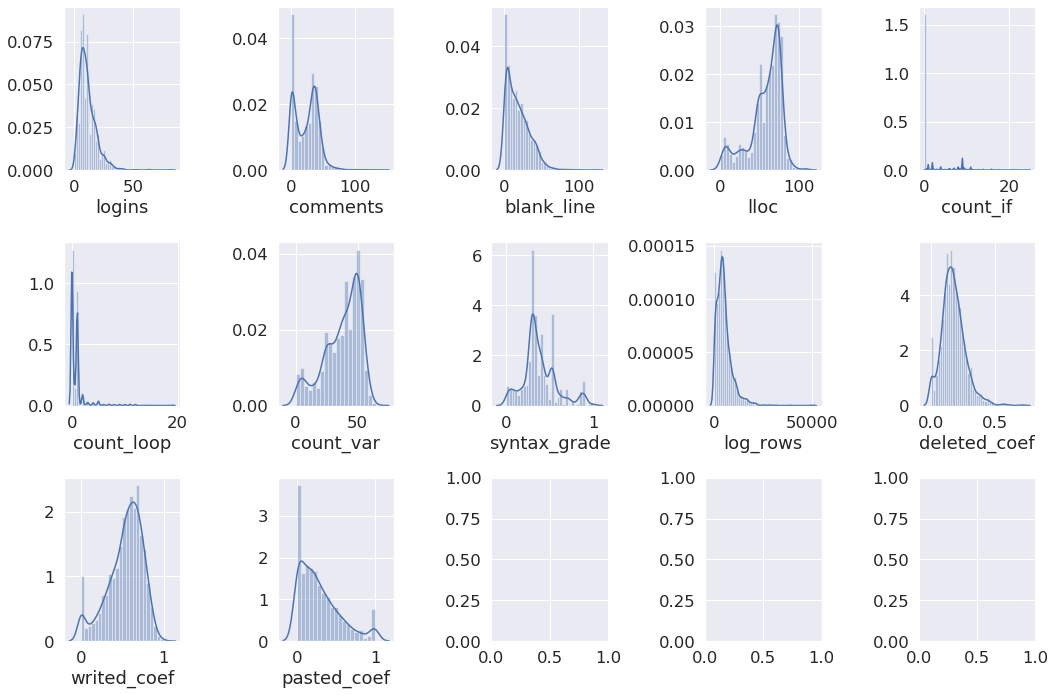

In [9]:
df = dfs[session].iloc[:,2:first_half]

fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))

for i,col in enumerate(df.columns.to_list()):
    row = i//5
    pos = i % 5
    ax = sns.distplot(df[col], ax=axs[row][pos])
    #ax = sns.kdeplot(data=df, x=col, hue="situation", multiple="stack", hue_order=['passed', 'failed'], fill=True, ax=axs[row][pos], legend=False, alpha=.5)
    ax.set_ylabel('')
    
plt.tight_layout()
#plt.savefig('figs/grid_hist9.pdf', format='pdf')

* Distribuições extramamente preocupantes (valores de outliers muito altos): 
    * pasted e focus time, blank_line, logins.
* Distribuições preocupantes (valores de outliers altos): 
    * comments, log_rows, count_delete.

### Análise das Últimas 15 colunas

In [10]:
dfs[session].iloc[:,first_half:-2].head()

,focus_time,writed_time,procastination,error_coef,submit_coef,jadud,amount_of_change,correct,incorrect,blank,homework_grade,exam_grade
0,54.894066,20.445817,46.840154,0.098361,0.163934,5.291503,40.755368,1.000000,0.000000,0.000000,10.00,10.0
1,5.203117,2.394250,23.494680,0.000000,0.250000,0.000000,0.000000,0.315789,0.157895,0.526316,4.07,0.0
2,54.093500,20.171050,138.920841,0.000000,0.714286,0.000000,17.972201,1.000000,0.000000,0.000000,10.00,10.0
3,75.616433,25.505217,104.818891,0.500000,0.333333,11.618950,24.556058,1.000000,0.000000,0.000000,10.00,10.0
4,70.632867,26.359367,143.579246,0.142857,0.428571,3.316625,10.630146,0.736842,0.000000,0.263158,8.00,5.0


* Qual a diferença de **blank** para **blank_lines**?

In [11]:
df = dfs[session].iloc[:,first_half:-2]
stats = df.describe()
stats.loc['skew'] = df.skew().tolist()
stats.loc['kurt'] = df.kurtosis().tolist()
stats

,focus_time,writed_time,procastination,error_coef,submit_coef,jadud,amount_of_change,correct,incorrect,blank,homework_grade,exam_grade
count,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000,2007.000000
mean,75.371187,19.868350,97.404704,0.385186,0.434097,12.843301,35.830738,0.852167,0.027191,0.120643,8.591430,5.993637
std,54.350331,13.497870,53.752953,0.244255,0.271988,10.373342,23.477828,0.205647,0.041915,0.190486,2.143746,4.482637
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.213417,10.313450,58.191440,0.204605,0.222222,4.690416,18.854703,0.785714,0.000000,0.000000,7.620000,0.000000
50%,69.198601,19.463950,98.681305,0.379310,0.400000,11.532563,33.166248,0.944444,0.000000,0.000000,10.000000,10.000000
75%,102.524300,27.059300,132.238420,0.545455,0.625000,19.078766,48.943843,1.000000,0.050000,0.171429,10.000000,10.000000
max,497.746827,174.822383,507.961613,1.000000,1.000000,60.934391,152.600786,1.000000,0.315789,1.000000,10.000000,10.000000
skew,1.484756,1.581336,0.502763,0.418923,0.443340,0.897997,0.843656,-1.823081,2.143677,2.042487,-1.747098,-0.401945
kurt,4.854969,10.241893,1.845327,-0.154968,-0.675334,0.946459,1.281987,3.127863,6.226439,4.197392,2.697586,-1.641815


In [12]:
1.543978*(10**6)

1543978.0

* O que seria o is_right e wrong_sumit? Outra coisa, observa os valores máximos dessa feature, 187 e 3942, respectivamente.
* Como foi calculado o procrastination? O valor máximo está extremamente alto.
* Verificar valores máximos de cada variável.
* A olha o skewness e kurtosis do deleted_time, pasted_time, tested, submited, wrong_submit, syntax_error, jadud, amount_of_change, incorrect.
* Como você está agregando variáveis binárias?
* Essas variáveis de tempo precisam ser verificadas com calma. Talvez seja o caso de aplicar algum filtro para não deixar passar anomalias.
* Por que o syntaxError é maior que o wrong_submit?
* mudar nome do procrastination do jeito que está sendo calculado para earlyOften
* Acrescentar variável procrastinaçao_i = data do primeiros acesso ao problema i - start da lista em que o problema i está incluído.

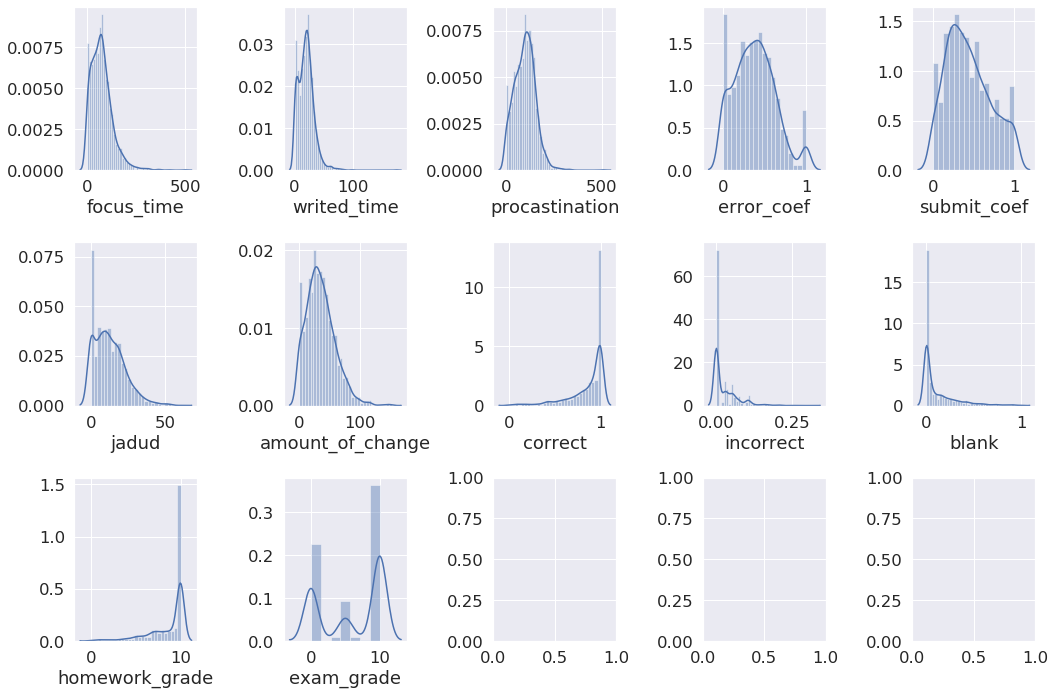

In [13]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))

for i,col in enumerate(df.columns.to_list()):
    row = i//5
    pos = i % 5
    ax = sns.distplot(df[col], ax=axs[row][pos])
    #ax = sns.kdeplot(data=df, x=col, hue="situation", multiple="stack", hue_order=['passed', 'failed'], fill=True, ax=axs[row][pos], legend=False, alpha=.5)
    ax.set_ylabel('')
    
plt.tight_layout()

* Todas as distribuições que ficam bem "magrinhas" comprimidas no canto estão assim por causa da presença de outliers. Essas que estão afastadas para a esquerda ou direita e com a calda longa também estão assim por causa dos outliers.